In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from PIL import Image

import flickr_api
from flickr_api import Photo
from sklearn.cluster import DBSCAN

from dataset.load import LoadDataset
from dataset.utils import load_credentials, get_photo
from utils.vis import make_tensor, visualize_grid

api_key, api_secret = load_credentials()
flickr_api.set_keys(api_key=api_key, api_secret=api_secret)

In [3]:
# Load dataset and count number of photos
path = "data/paris_10000.h5"
dataset = LoadDataset(path)
print(dataset.size(), "photos")

4216 photos


In [4]:
# Get features from dataset
it = dataset.get()
X = []
for i, row in enumerate(it):
    metadata, embedding = row
    lat = float(metadata["location"]["latitude"])
    lon = float(metadata["location"]["longitude"])
    id = int(metadata["id"])
    X.append([id, lat, lon])

X = np.asarray(X)
X.shape

(4216, 3)

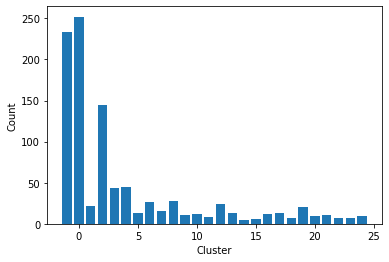

In [54]:
# Sampling on a smaller subset
train_idx = np.random.choice(X.shape[0], size=1000, replace=False)
sample = X[train_idx]
X_train = sample[:, 1:]

# Train clustering using DBSCAN
kms_per_radian = 6371.0088
meters = 300
epsilon = (meters * 0.001) / kms_per_radian
db = DBSCAN(eps=epsilon, algorithm='ball_tree', metric='haversine')
db.fit(np.radians(X_train))
y_train = db.labels_
fig, ax = plt.subplots()
ax.bar(*np.unique(y_train, return_counts=True))
ax.set_xlabel("Cluster")
ax.set_ylabel("Count")
plt.show()

In [55]:
# Get images in clusters
cluster_imgs = {}
for label in set(y_train):
    if label == -1: continue
    photos_id = sample[y_train == label, 0]
    cluster_imgs[label] = []
    subset = np.random.choice(photos_id.shape[0], size=min(photos_id.shape[0], 10), replace=False)
    for photo_id in photos_id[subset]:
        p = Photo(id=photo_id)
        img = get_photo(p)
        cluster_imgs[label].append(img)

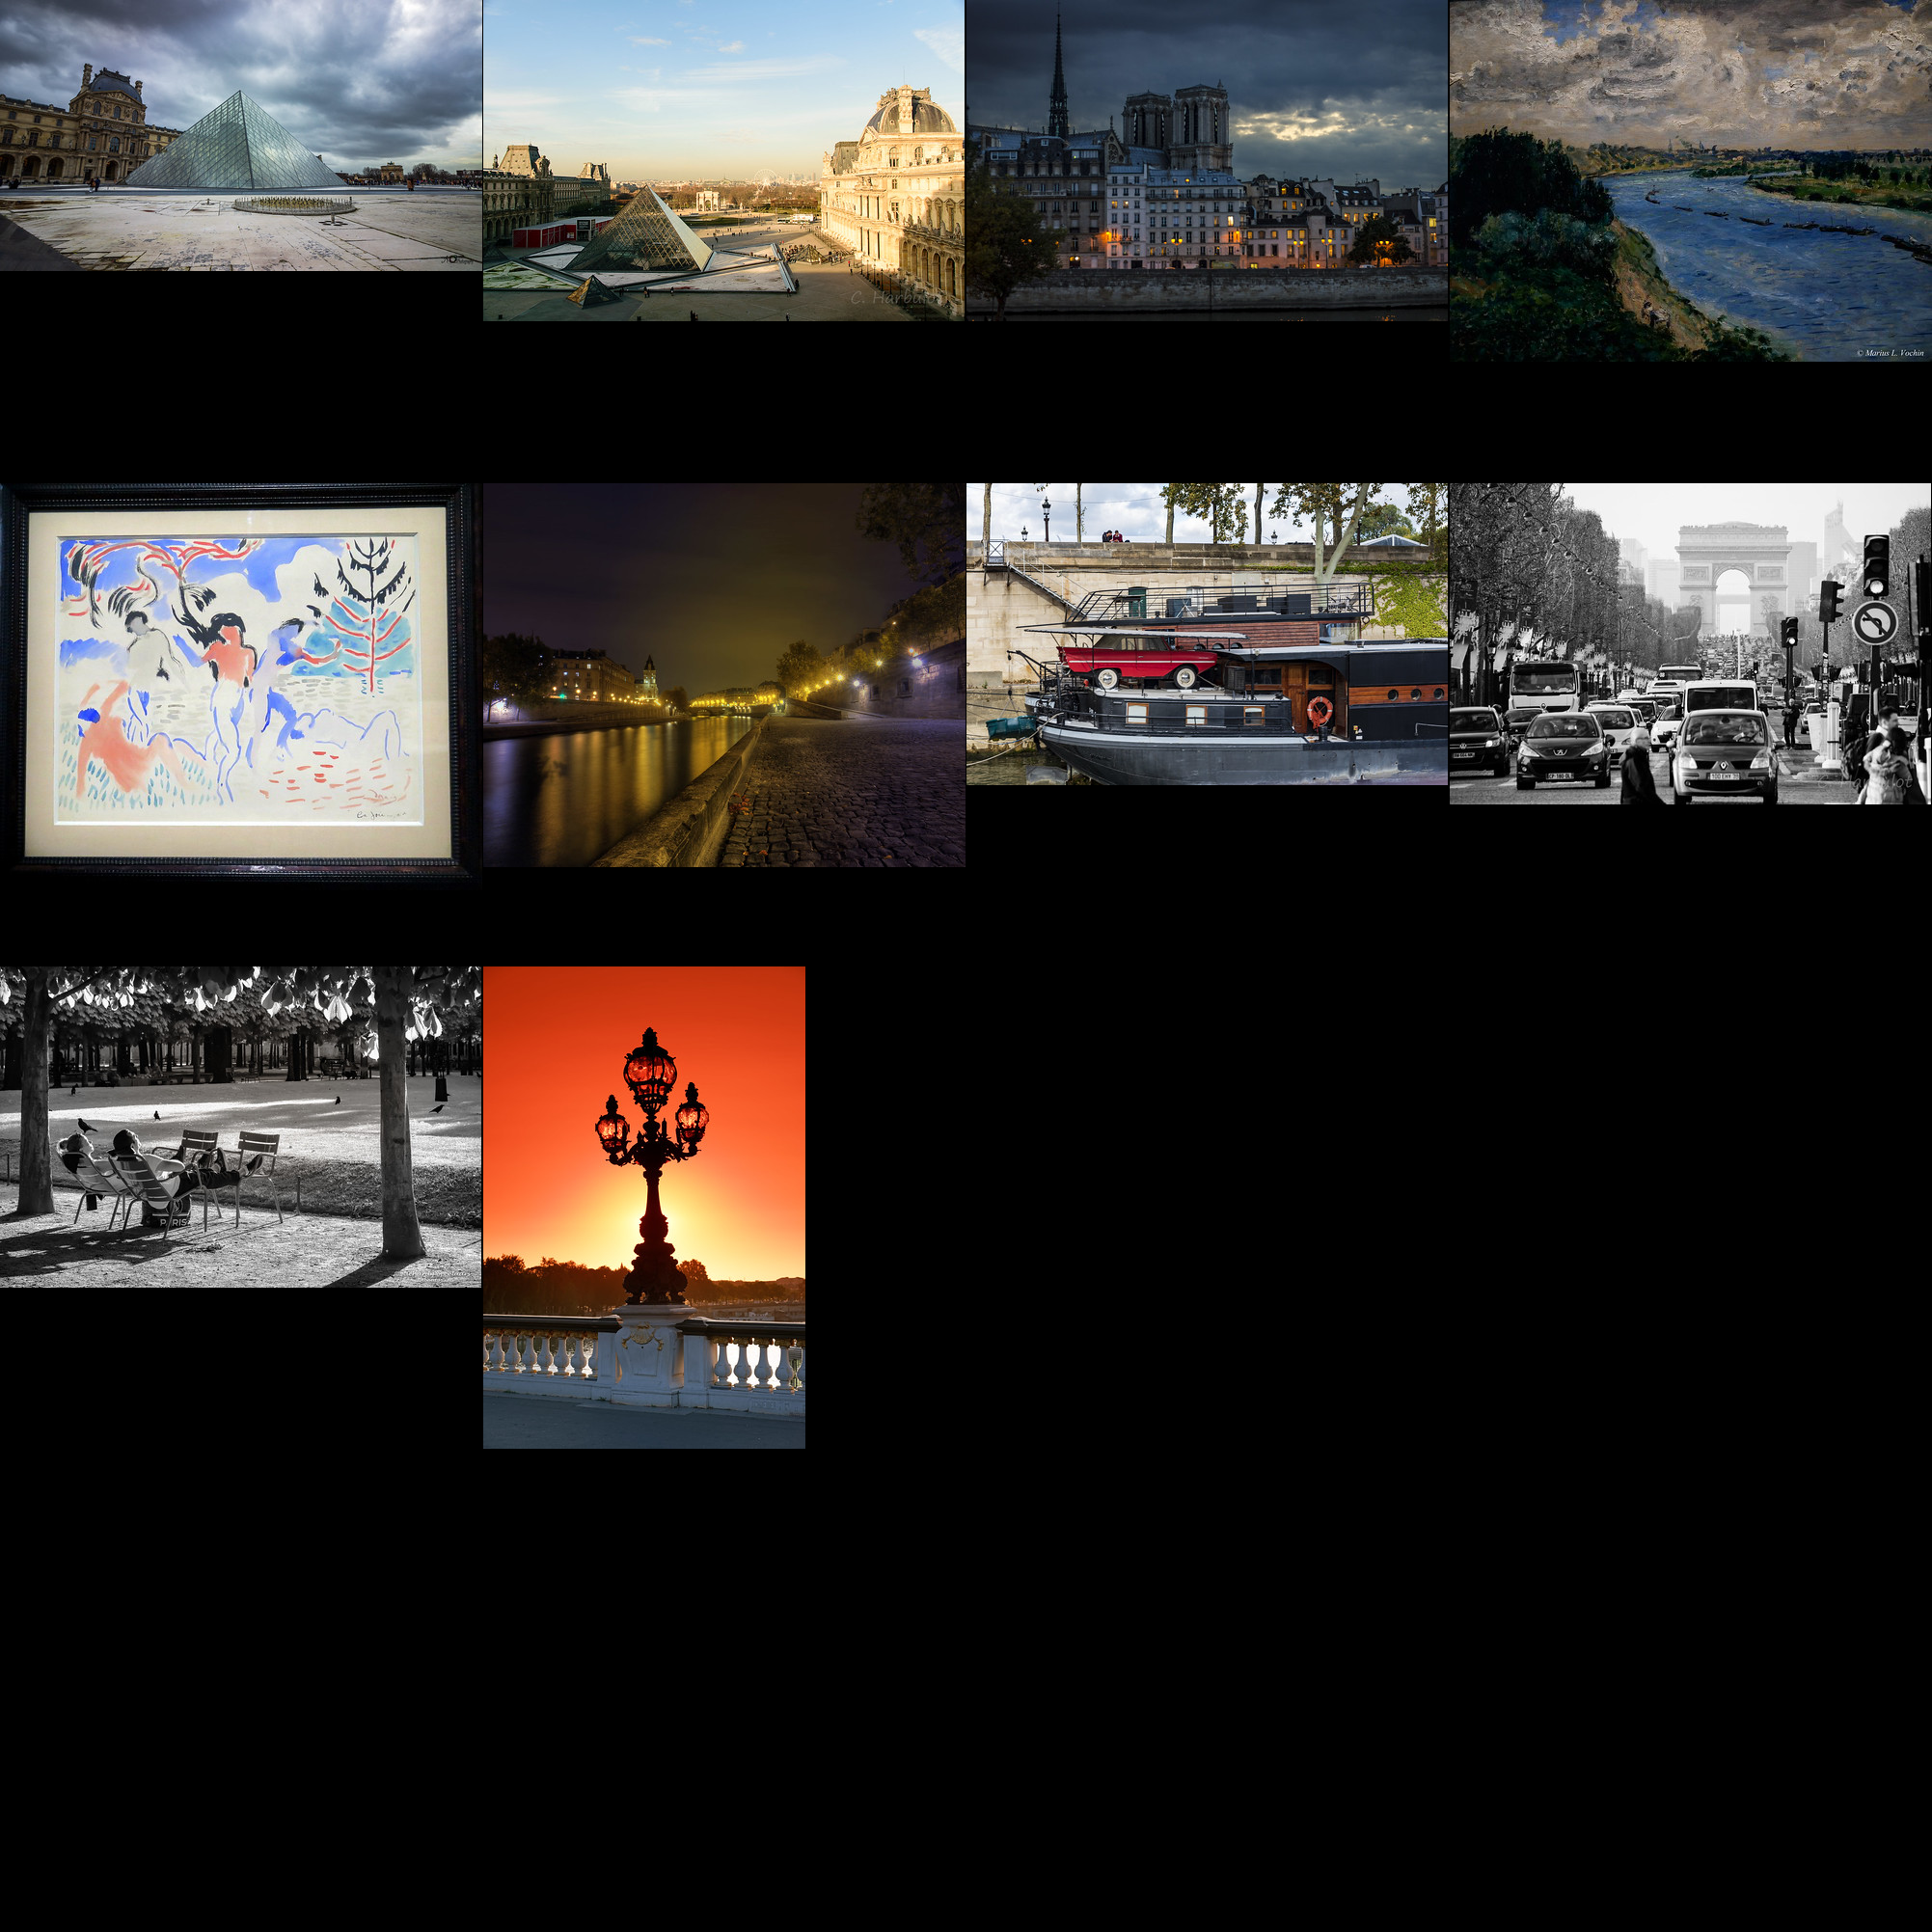

In [62]:
# Visualize photos from the same cluster
cluster_label = 0
grid = visualize_grid(make_tensor(cluster_imgs[cluster_label]))
Image.fromarray(grid.astype("uint8"))



In [71]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_cluster_sim(X):
    embedding_X = [dataset.get_id(int(photo_id))[1] for photo_id in X[:, 0]]
    embedding_X = np.stack(embedding_X, axis=0)
    return cosine_similarity(embedding_X).mean()

# Quantitative measure of the clusters
cluster_similarities = {}
for label in set(y_train):
    if label == -1: continue
    cluster_X = sample[y_train == label]
    cluster_sim = compute_cluster_sim(cluster_X)
    cluster_similarities[label] = cluster_sim

cluster_similarities

{0: 0.63234866,
 1: 0.66323173,
 2: 0.65857136,
 3: 0.58757424,
 4: 0.6558822,
 5: 0.6541531,
 6: 0.6991737,
 7: 0.664799,
 8: 0.69828594,
 9: 0.6620036,
 10: 0.6951591,
 11: 0.6973118,
 12: 0.727673,
 13: 0.7591447,
 14: 0.6225664,
 15: 0.80764586,
 16: 0.7017545,
 17: 0.63353366,
 18: 0.6388646,
 19: 0.63463056,
 20: 0.6240165,
 21: 0.7025655,
 22: 0.73920953,
 23: 0.7075801,
 24: 0.65756536}